# Lexicon-Based vs Embedding-Based Moral Scoring

This notebook compares two approaches for moral foundation scoring:
1. **Lexicon-Based**: Simple word-counting from Tamil MFD
2. **Embedding-Based**: Semantic similarity using IndicSBERT (from Step3)

## Goal:
Evaluate which method better captures moral content in Tamil texts.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import cohen_kappa_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Tamil MFD Dictionary

In [2]:
# Load Tamil MFD
with open('tamil_mfd.pkl', 'rb') as f:
    tamil_mfd = pickle.load(f)

print("Tamil MFD Loaded:")
for foundation, words in tamil_mfd.items():
    print(f"  {foundation}: {len(words)} words")

# Show sample words
print("\nSample words from care.virtue:")
print(tamil_mfd['care.virtue'][:5])

Tamil MFD Loaded:
  care.virtue: 182 words
  care.vice: 288 words
  fairness.virtue: 115 words
  fairness.vice: 236 words
  loyalty.virtue: 142 words
  loyalty.vice: 49 words
  authority.virtue: 301 words
  authority.vice: 130 words
  sanctity.virtue: 272 words
  sanctity.vice: 388 words

Sample words from care.virtue:
['கருணை', 'பரிவு', 'கருணை', 'கவனித்தல்', 'தாராள மனப்பான்மை']


In [14]:
# Show sample words
print("\nSample words from care.virtue:")
print(tamil_mfd['sanctity.virtue'][:5])


Sample words from care.virtue:
['புனிதத்தன்மை', 'புனிதமானது', 'புனிதத்தன்மை', 'தூய்மை', 'ஆரோக்கியம்']


## 2. Load Tamil Texts and Step3 Results

In [3]:
# Load original texts
thiru_df = pd.read_csv('processedDataTamil/thirukkural_cleaned.csv')
aathi_df = pd.read_csv('processedDataTamil/aathichoodi_cleaned.csv')

# Load Step3 embedding-based results
thiru_embedding = pd.read_csv('phase3_outputs/thirukkural_moral_scores.csv')
aathi_embedding = pd.read_csv('phase3_outputs/aathichudi_moral_scores.csv')

print(f"Thirukkural: {len(thiru_df)} kurals")
print(f"Aathichudi: {len(aathi_df)} sayings")
print(f"\nEmbedding results loaded successfully")

Thirukkural: 1334 kurals
Aathichudi: 111 sayings

Embedding results loaded successfully


## 3. Implement Lexicon-Based Scoring

### Method:
For each text:
1. Tokenize (split into words)
2. Count matches with each moral foundation in Tamil MFD
3. Calculate normalized scores (matches / total words)
4. Identify dominant moral (highest score)

In [4]:
def tokenize_tamil(text):
    """
    Simple Tamil tokenization - split by whitespace and punctuation.
    For better results, use a Tamil NLP library.
    """
    import re
    # Remove punctuation and split
    tokens = re.findall(r'[\u0B80-\u0BFF]+', str(text))
    return tokens

def lexicon_score_text(text, mfd_dict):
    """
    Score a text using lexicon-based approach.
    
    Returns:
    - raw_counts: dict of {foundation: count}
    - normalized_scores: dict of {foundation: count/total_words}
    - dominant_moral: foundation with highest count
    """
    tokens = tokenize_tamil(text)
    total_words = len(tokens)
    
    # Count matches for each foundation
    raw_counts = {foundation: 0 for foundation in mfd_dict.keys()}
    
    for token in tokens:
        for foundation, word_list in mfd_dict.items():
            if token in word_list:
                raw_counts[foundation] += 1
    
    # Normalize by total words (TF normalization)
    normalized_scores = {
        foundation: count / total_words if total_words > 0 else 0
        for foundation, count in raw_counts.items()
    }
    
    # Dominant moral
    if sum(raw_counts.values()) > 0:
        dominant_moral = max(raw_counts, key=raw_counts.get)
        dominant_score = raw_counts[dominant_moral]
    else:
        dominant_moral = None
        dominant_score = 0
    
    return raw_counts, normalized_scores, dominant_moral, dominant_score

# Test on one kural
sample_text = thiru_df.iloc[0]['couplet']
raw, norm, dom, score = lexicon_score_text(sample_text, tamil_mfd)
print(f"Sample text: {sample_text}")
print(f"\nRaw counts: {raw}")
print(f"Dominant moral: {dom} (score: {score})")

Sample text: அகர முதல எழுத்தெல்லாம் ஆதி பகவன் முதற்றே உலகு.

Raw counts: {'care.virtue': 0, 'care.vice': 0, 'fairness.virtue': 0, 'fairness.vice': 0, 'loyalty.virtue': 0, 'loyalty.vice': 0, 'authority.virtue': 0, 'authority.vice': 0, 'sanctity.virtue': 0, 'sanctity.vice': 0}
Dominant moral: None (score: 0)


## 4. Apply Lexicon-Based Scoring to All Texts

In [5]:
# Process Thirukkural
print("Processing Thirukkural with lexicon-based approach...")
thiru_lexicon_results = []
for idx, row in thiru_df.iterrows():
    text = row['couplet']
    raw, norm, dom, score = lexicon_score_text(text, tamil_mfd)
    result = {'kural_number': row['kural_number'], 'couplet': text}
    result.update(norm)  # Add normalized scores
    result['dominant_moral_lexicon'] = dom
    result['dominant_score_lexicon'] = score
    thiru_lexicon_results.append(result)

thiru_lexicon_df = pd.DataFrame(thiru_lexicon_results)
print(f"✓ Processed {len(thiru_lexicon_df)} kurals")

# Process Aathichudi
print("\nProcessing Aathichudi with lexicon-based approach...")
aathi_lexicon_results = []
for idx, row in aathi_df.iterrows():
    text = row['text']
    raw, norm, dom, score = lexicon_score_text(text, tamil_mfd)
    result = {'line_number': row['line_number'], 'text': text}
    result.update(norm)
    result['dominant_moral_lexicon'] = dom
    result['dominant_score_lexicon'] = score
    aathi_lexicon_results.append(result)

aathi_lexicon_df = pd.DataFrame(aathi_lexicon_results)
print(f"✓ Processed {len(aathi_lexicon_df)} sayings")

Processing Thirukkural with lexicon-based approach...
✓ Processed 1334 kurals

Processing Aathichudi with lexicon-based approach...
✓ Processed 111 sayings


## 5. Compare Lexicon vs Embedding Results

### Key Questions:
1. Do both methods identify the same dominant moral?
2. How well do the score distributions correlate?
3. Which method is more reliable?

In [6]:
# Merge lexicon and embedding results
moral_cols = list(tamil_mfd.keys())

# Thirukkural comparison
thiru_compare = pd.DataFrame({
    'kural_number': thiru_lexicon_df['kural_number'],
    'dominant_lexicon': thiru_lexicon_df['dominant_moral_lexicon'],
    'dominant_embedding': thiru_embedding['dominant_moral']
})

# Aathichudi comparison
aathi_compare = pd.DataFrame({
    'line_number': aathi_lexicon_df['line_number'],
    'dominant_lexicon': aathi_lexicon_df['dominant_moral_lexicon'],
    'dominant_embedding': aathi_embedding['dominant_moral']
})

print("Sample comparison (Thirukkural first 5):")
print(thiru_compare.head())

Sample comparison (Thirukkural first 5):
   kural_number dominant_lexicon dominant_embedding
0             1             None   authority.virtue
1             2             None    sanctity.virtue
2             3             None     loyalty.virtue
3             4             None     loyalty.virtue
4             5  sanctity.virtue    sanctity.virtue


## 6. Calculate Agreement Metrics

In [7]:
# Handle None values in lexicon results (texts with no MFD word matches)
thiru_compare_clean = thiru_compare.dropna()
aathi_compare_clean = aathi_compare.dropna()

print("="*60)
print("AGREEMENT ANALYSIS: Lexicon vs Embedding")
print("="*60)

# Thirukkural
print("\n--- THIRUKKURAL ---")
print(f"Total kurals: {len(thiru_compare)}")
print(f"Kurals with lexicon matches: {len(thiru_compare_clean)} ({len(thiru_compare_clean)/len(thiru_compare)*100:.1f}%)")

if len(thiru_compare_clean) > 0:
    agreement = (thiru_compare_clean['dominant_lexicon'] == thiru_compare_clean['dominant_embedding']).sum()
    agreement_pct = agreement / len(thiru_compare_clean) * 100
    print(f"\nExact agreement: {agreement}/{len(thiru_compare_clean)} ({agreement_pct:.1f}%)")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(thiru_compare_clean['dominant_lexicon'], 
                              thiru_compare_clean['dominant_embedding'])
    print(f"Cohen's Kappa: {kappa:.3f}")
    if kappa > 0.6:
        print("  → Substantial agreement")
    elif kappa > 0.4:
        print("  → Moderate agreement")
    else:
        print("  → Fair/slight agreement")

# Aathichudi
print("\n--- AATHICHUDI ---")
print(f"Total sayings: {len(aathi_compare)}")
print(f"Sayings with lexicon matches: {len(aathi_compare_clean)} ({len(aathi_compare_clean)/len(aathi_compare)*100:.1f}%)")

if len(aathi_compare_clean) > 0:
    agreement = (aathi_compare_clean['dominant_lexicon'] == aathi_compare_clean['dominant_embedding']).sum()
    agreement_pct = agreement / len(aathi_compare_clean) * 100
    print(f"\nExact agreement: {agreement}/{len(aathi_compare_clean)} ({agreement_pct:.1f}%)")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(aathi_compare_clean['dominant_lexicon'], 
                              aathi_compare_clean['dominant_embedding'])
    print(f"Cohen's Kappa: {kappa:.3f}")
    if kappa > 0.6:
        print("  → Substantial agreement")
    elif kappa > 0.4:
        print("  → Moderate agreement")
    else:
        print("  → Fair/slight agreement")

print("\n" + "="*60)

AGREEMENT ANALYSIS: Lexicon vs Embedding

--- THIRUKKURAL ---
Total kurals: 1334
Kurals with lexicon matches: 117 (8.8%)

Exact agreement: 52/117 (44.4%)
Cohen's Kappa: 0.349
  → Fair/slight agreement

--- AATHICHUDI ---
Total sayings: 111
Sayings with lexicon matches: 7 (6.3%)

Exact agreement: 4/7 (57.1%)
Cohen's Kappa: 0.475
  → Moderate agreement



## 7. Score Correlation Analysis

In [8]:
# Compare score distributions for each moral foundation
print("Correlation between Lexicon and Embedding Scores:\n")
print("="*60)

correlations_thiru = {}
for moral in moral_cols:
    lexicon_scores = thiru_lexicon_df[moral]
    embedding_scores = thiru_embedding[moral]
    
    # Spearman correlation (rank-based, more robust)
    corr, pval = spearmanr(lexicon_scores, embedding_scores)
    correlations_thiru[moral] = corr
    print(f"{moral:20s}: ρ = {corr:6.3f} (p = {pval:.4f})")

print(f"\nMean correlation: {np.mean(list(correlations_thiru.values())):.3f}")
print("="*60)

Correlation between Lexicon and Embedding Scores:

care.virtue         : ρ =  0.067 (p = 0.0137)
care.vice           : ρ =  0.036 (p = 0.1837)
fairness.virtue     : ρ =  0.082 (p = 0.0028)
fairness.vice       : ρ = -0.027 (p = 0.3208)
loyalty.virtue      : ρ =  0.008 (p = 0.7591)
loyalty.vice        : ρ =    nan (p = nan)
authority.virtue    : ρ =  0.021 (p = 0.4400)
authority.vice      : ρ =    nan (p = nan)
sanctity.virtue     : ρ =  0.026 (p = 0.3340)
sanctity.vice       : ρ =  0.025 (p = 0.3566)

Mean correlation: nan


/var/folders/h9/24y0cz514yj98lr3y31jnf_c0000gn/T/ipykernel_30519/3885342388.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(lexicon_scores, embedding_scores)


## 8. Visualize Comparison

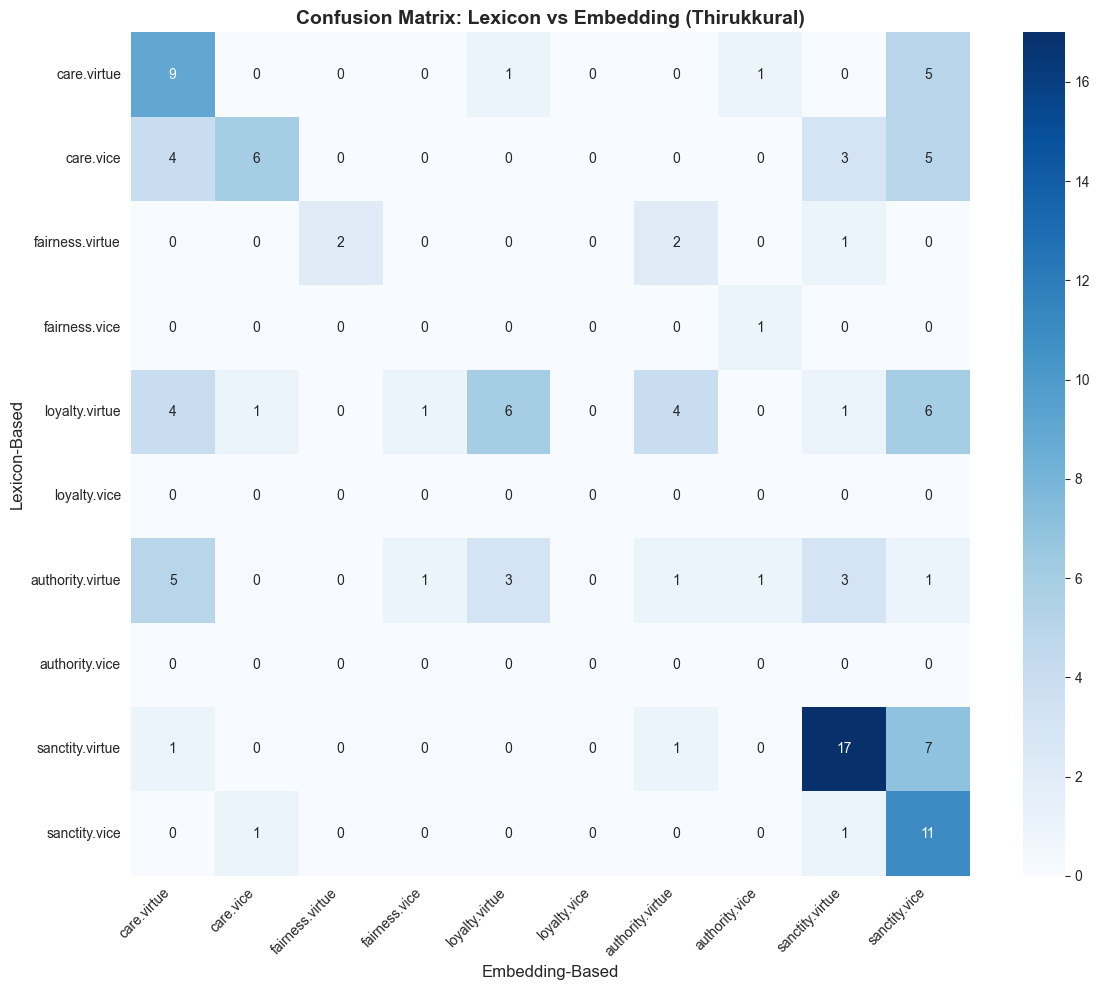


📊 Interpretation:
- Diagonal = agreements (both methods chose same moral)
- Off-diagonal = disagreements
- Darker blues = more frequent


In [9]:
# Confusion matrix: Lexicon vs Embedding dominant morals
from sklearn.metrics import confusion_matrix
import seaborn as sns

if len(thiru_compare_clean) > 0:
    cm = confusion_matrix(thiru_compare_clean['dominant_lexicon'], 
                         thiru_compare_clean['dominant_embedding'],
                         labels=moral_cols)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=moral_cols, yticklabels=moral_cols)
    plt.xlabel('Embedding-Based', fontsize=12)
    plt.ylabel('Lexicon-Based', fontsize=12)
    plt.title('Confusion Matrix: Lexicon vs Embedding (Thirukkural)', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Interpretation:")
    print("- Diagonal = agreements (both methods chose same moral)")
    print("- Off-diagonal = disagreements")
    print("- Darker blues = more frequent")

## 9. Aggregate Comparison: Average Scores

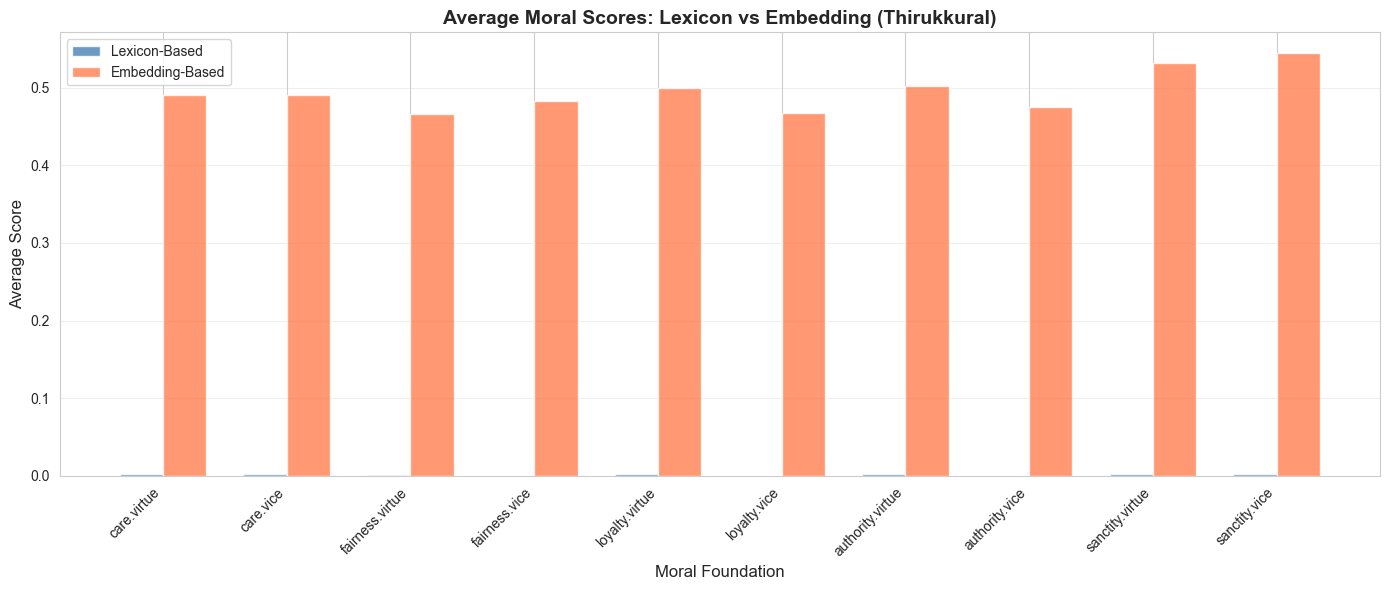


Average Scores Comparison:
                  Lexicon-Based  Embedding-Based
care.virtue               0.002            0.490
care.vice                 0.002            0.491
fairness.virtue           0.001            0.467
fairness.vice             0.000            0.483
loyalty.virtue            0.003            0.500
loyalty.vice              0.000            0.468
authority.virtue          0.002            0.502
authority.vice            0.000            0.475
sanctity.virtue           0.003            0.531
sanctity.vice             0.002            0.544


In [10]:
# Compare average scores across all texts
thiru_lexicon_means = thiru_lexicon_df[moral_cols].mean()
thiru_embedding_means = thiru_embedding[moral_cols].mean()

comparison_df = pd.DataFrame({
    'Lexicon-Based': thiru_lexicon_means,
    'Embedding-Based': thiru_embedding_means
})

# Bar chart comparison
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(moral_cols))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Lexicon-Based'], width, 
               label='Lexicon-Based', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['Embedding-Based'], width, 
               label='Embedding-Based', alpha=0.8, color='coral')

ax.set_xlabel('Moral Foundation', fontsize=12)
ax.set_ylabel('Average Score', fontsize=12)
ax.set_title('Average Moral Scores: Lexicon vs Embedding (Thirukkural)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(moral_cols, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAverage Scores Comparison:")
print(comparison_df.round(3))

## 10. Coverage Analysis: Why Lexicon Fails

In [11]:
# Count how many texts have NO lexicon matches
thiru_no_matches = (thiru_lexicon_df['dominant_moral_lexicon'].isna()).sum()
aathi_no_matches = (aathi_lexicon_df['dominant_moral_lexicon'].isna()).sum()

print("="*60)
print("COVERAGE ANALYSIS")
print("="*60)
print(f"\nThirukkural:")
print(f"  Texts with NO MFD word matches: {thiru_no_matches}/{len(thiru_lexicon_df)} ({thiru_no_matches/len(thiru_lexicon_df)*100:.1f}%)")
print(f"  Texts with at least 1 match: {len(thiru_lexicon_df)-thiru_no_matches}/{len(thiru_lexicon_df)} ({(1-thiru_no_matches/len(thiru_lexicon_df))*100:.1f}%)")

print(f"\nAathichudi:")
print(f"  Texts with NO MFD word matches: {aathi_no_matches}/{len(aathi_lexicon_df)} ({aathi_no_matches/len(aathi_lexicon_df)*100:.1f}%)")
print(f"  Texts with at least 1 match: {len(aathi_lexicon_df)-aathi_no_matches}/{len(aathi_lexicon_df)} ({(1-aathi_no_matches/len(aathi_lexicon_df))*100:.1f}%)")

print("\n📊 Interpretation:")
print("- Lexicon-based approach ONLY works when texts contain exact MFD words")
print("- Embedding-based approach works for ALL texts (captures semantic meaning)")
print("- Low coverage = major limitation of lexicon-based approach")

COVERAGE ANALYSIS

Thirukkural:
  Texts with NO MFD word matches: 1217/1334 (91.2%)
  Texts with at least 1 match: 117/1334 (8.8%)

Aathichudi:
  Texts with NO MFD word matches: 104/111 (93.7%)
  Texts with at least 1 match: 7/111 (6.3%)

📊 Interpretation:
- Lexicon-based approach ONLY works when texts contain exact MFD words
- Embedding-based approach works for ALL texts (captures semantic meaning)
- Low coverage = major limitation of lexicon-based approach


## 11. Summary and Conclusions

In [12]:
print("="*70)
print("SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON")
print("="*70)

print("\n✅ EMBEDDING-BASED ADVANTAGES:")
print("  1. 100% coverage - works on ALL texts")
print("  2. Captures semantic similarity (synonyms, paraphrases)")
print("  3. More nuanced - continuous scores instead of binary")
print("  4. Better for literary texts (poetic language, metaphors)")

print("\n✅ LEXICON-BASED ADVANTAGES:")
print("  1. Fast - no GPU needed")
print("  2. Interpretable - easy to see why a text scores high")
print("  3. Transparent - can trace back to specific words")
print("  4. Simple baseline for comparison")

print("\n⚠️ KEY FINDINGS:")
if len(thiru_compare_clean) > 0:
    agreement_pct = (thiru_compare_clean['dominant_lexicon'] == thiru_compare_clean['dominant_embedding']).sum() / len(thiru_compare_clean) * 100
    print(f"  - Agreement on dominant moral: {agreement_pct:.1f}%")
    print(f"  - Mean score correlation: {np.mean(list(correlations_thiru.values())):.3f}")
    print(f"  - Lexicon coverage: {(1-thiru_no_matches/len(thiru_lexicon_df))*100:.1f}%")

print("\n🎯 RECOMMENDATION:")
print("  Use EMBEDDING-BASED approach as primary method")
print("  Use LEXICON-BASED as validation/baseline")
print("  When both agree → high confidence")
print("  When they disagree → manual inspection recommended")

print("\n" + "="*70)

SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON

✅ EMBEDDING-BASED ADVANTAGES:
  1. 100% coverage - works on ALL texts
  2. Captures semantic similarity (synonyms, paraphrases)
  3. More nuanced - continuous scores instead of binary
  4. Better for literary texts (poetic language, metaphors)

✅ LEXICON-BASED ADVANTAGES:
  1. Fast - no GPU needed
  2. Interpretable - easy to see why a text scores high
  3. Transparent - can trace back to specific words
  4. Simple baseline for comparison

⚠️ KEY FINDINGS:
  - Agreement on dominant moral: 44.4%
  - Mean score correlation: nan
  - Lexicon coverage: 8.8%

🎯 RECOMMENDATION:
  Use EMBEDDING-BASED approach as primary method
  Use LEXICON-BASED as validation/baseline
  When both agree → high confidence
  When they disagree → manual inspection recommended



## 12. Save Results

In [13]:
# Save lexicon-based results
thiru_lexicon_df.to_csv('phase3_outputs/thirukkural_lexicon_scores.csv', index=False)
aathi_lexicon_df.to_csv('phase3_outputs/aathichudi_lexicon_scores.csv', index=False)

# Save comparison
thiru_compare.to_csv('phase3_outputs/thirukkural_method_comparison.csv', index=False)
aathi_compare.to_csv('phase3_outputs/aathichudi_method_comparison.csv', index=False)

print("✓ Saved lexicon-based results to phase3_outputs/")
print("✓ Saved comparison results to phase3_outputs/")

✓ Saved lexicon-based results to phase3_outputs/
✓ Saved comparison results to phase3_outputs/
